Import libraries

In [78]:
import numpy as np
import math
import re
import scipy
import statsmodels as sm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

In [3]:
os.getcwd()

'C:\\Users\\RegenwetterLab\\CS412'

# Dataset

## Data Preprocessing

load 4 sub datasets  (skip date)

In [4]:
dt1 = pd.read_csv('C:/Users/RegenwetterLab/CS412/DATA/combined_data_1.txt', header = None, names = ['user_id', 'rating'], usecols = [0,1])
dt2 = pd.read_csv('C:/Users/RegenwetterLab/CS412/DATA/combined_data_2.txt', header = None, names = ['user_id', 'rating'], usecols = [0,1])
dt3 = pd.read_csv('C:/Users/RegenwetterLab/CS412/DATA/combined_data_3.txt', header = None, names = ['user_id', 'rating'], usecols = [0,1])
dt4 = pd.read_csv('C:/Users/RegenwetterLab/CS412/DATA/combined_data_4.txt', header = None, names = ['user_id', 'rating'], usecols = [0,1])

In [5]:
dt_all = pd.concat([dt1, dt2, dt3, dt4])
dt_all.info()
print(dt_all.head())
print(dt_all.tail())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100498277 entries, 0 to 26851925
Data columns (total 2 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   rating   float64
dtypes: float64(1), object(1)
memory usage: 2.2+ GB
   user_id  rating
0       1:     NaN
1  1488844     3.0
2   822109     5.0
3   885013     4.0
4    30878     4.0
          user_id  rating
26851921  1790158     4.0
26851922  1608708     3.0
26851923   234275     1.0
26851924   255278     4.0
26851925   453585     2.0


In [6]:
dt_all = dt_all.reset_index(drop = True)

In [7]:
dt_all.tail()

,user_id,rating
100498272,1790158,4.0
100498273,1608708,3.0
100498274,234275,1.0
100498275,255278,4.0
100498276,453585,2.0


In [8]:
dt_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100498277 entries, 0 to 100498276
Data columns (total 2 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   rating   float64
dtypes: float64(1), object(1)
memory usage: 1.5+ GB


Preprocess data by extracting movies and adding a new column "movie_id"

In [9]:
movies = dt_all[dt_all['rating'].isna()]['user_id']
movies = movies.str.strip(':')
movies = movies.to_frame().reset_index()
movies.columns = ['dt_all_index', 'movie_id']
movies.head(n=10)

,dt_all_index,movie_id
0,0,1
1,548,2
2,694,3
3,2707,4
4,2850,5
5,3991,6
6,5011,7
7,5105,8
8,20016,9
9,20112,10


In [10]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17770 entries, 0 to 17769
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   dt_all_index  17770 non-null  int64 
 1   movie_id      17770 non-null  object
dtypes: int64(1), object(1)
memory usage: 277.8+ KB


In [11]:
user_data = []
mid = movies['movie_id']
k = 0
for idx1,idx2 in zip(movies['dt_all_index'][0:], movies['dt_all_index'][1:]):
    temp = dt_all.loc[idx1+1:idx2-1].copy()
    temp['movie_id'] = mid[k]
    user_data.append(temp)
    k = k+1

In [12]:
# last movie
last_idx = movies.iloc[-1,0]
last_movie = movies.iloc[-1,1]
last_recod = dt_all.loc[last_idx+1:].copy()
last_recod['movie_id'] = last_movie
user_data.append(last_recod)

In [13]:
df = pd.concat(user_data)
df.info()
print(df.head())
print(df.tail())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100480507 entries, 1 to 100498276
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user_id   object 
 1   rating    float64
 2   movie_id  object 
dtypes: float64(1), object(2)
memory usage: 3.0+ GB
   user_id  rating movie_id
1  1488844     3.0        1
2   822109     5.0        1
3   885013     4.0        1
4    30878     4.0        1
5   823519     3.0        1
           user_id  rating movie_id
100498272  1790158     4.0    17770
100498273  1608708     3.0    17770
100498274   234275     1.0    17770
100498275   255278     4.0    17770
100498276   453585     2.0    17770


In [14]:
# reset index
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100480507 entries, 0 to 100480506
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user_id   object 
 1   rating    float64
 2   movie_id  object 
dtypes: float64(1), object(2)
memory usage: 2.2+ GB


In [15]:
# delete objects no longer needed to save memory
del user_data, dt1, dt2, dt3, dt4, dt_all, temp

## EDA
### Distribution of ratings


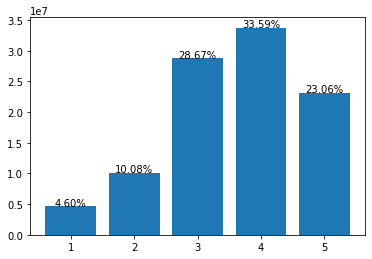

In [16]:
from locale import normalize
rating_counts = df['rating'].value_counts().sort_index()
rating_props = df['rating'].value_counts(normalize=True).sort_index()
fig, axes = plt.subplots()
bars = axes.bar(x = rating_counts.index, height = rating_counts.values)
for i, bar in enumerate(bars):
  height = bar.get_height()
  axes.text(x = bar.get_x() + bar.get_width()/2,
            y = height+10000,
            s = "{:.2f}%".format(rating_props.iloc[i] * 100),
            ha = 'center')
plt.show()

The distribution of ratings is left skewed. Fewer low ratings (1 and 2 stars) and most ratings (>60%) are 3 and 4 stars.

### Distribution of number of ratings each user gave

In [17]:
users_by_rating_cnt = df.groupby('user_id').count()['movie_id'].reset_index()

In [18]:
users_by_rating_cnt.shape

(480189, 2)

In [19]:
users_by_rating_cnt.rename(columns = {"movie_id": "rating_count"}, inplace=True)

In [20]:
users_by_rating_cnt.sort_values(by = ['rating_count'], ascending=False)

,user_id,rating_count
339650,305344,17653
356403,387418,17436
289238,2439493,16565
133319,1664010,15813
224670,2118461,14831
...,...,...
112487,1560179,1
346551,339212,1
68746,134227,1
49267,1245917,1


The min number of ratings each user gave is 1, while the max can reach 17653.

In [21]:
user_rating_cnt_props = users_by_rating_cnt.value_counts('rating_count', normalize=True).sort_index()
user_rating_cnt_props

rating_count
1        0.002643
2        0.004636
3        0.004109
4        0.003611
5        0.003555
           ...   
14831    0.000002
15813    0.000002
16565    0.000002
17436    0.000002
17653    0.000002
Length: 2782, dtype: float64

In [22]:
user_rating_cnt_props.sort_values(ascending = False).head(n=20)

rating_count
18    0.008372
23    0.008309
20    0.008280
21    0.008251
17    0.008159
19    0.008113
16    0.008101
26    0.008059
15    0.008057
24    0.008041
22    0.007997
25    0.007993
27    0.007878
28    0.007707
32    0.007651
29    0.007520
30    0.007489
31    0.007289
14    0.007274
33    0.007203
dtype: float64

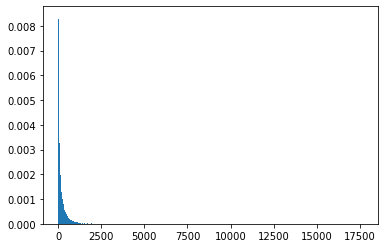

In [23]:
fig, axes2 = plt.subplots()
bars = axes2.bar(x = user_rating_cnt_props.index, height = user_rating_cnt_props.values)
plt.show()

The distribution of the number of ratings per user is extremely right skewed. There is a prominent exponential decay of frequency/proportion as the number of ratings increases. Let's put limits on the x-axis, the number of ratings per user, to more easily visualize the trend.

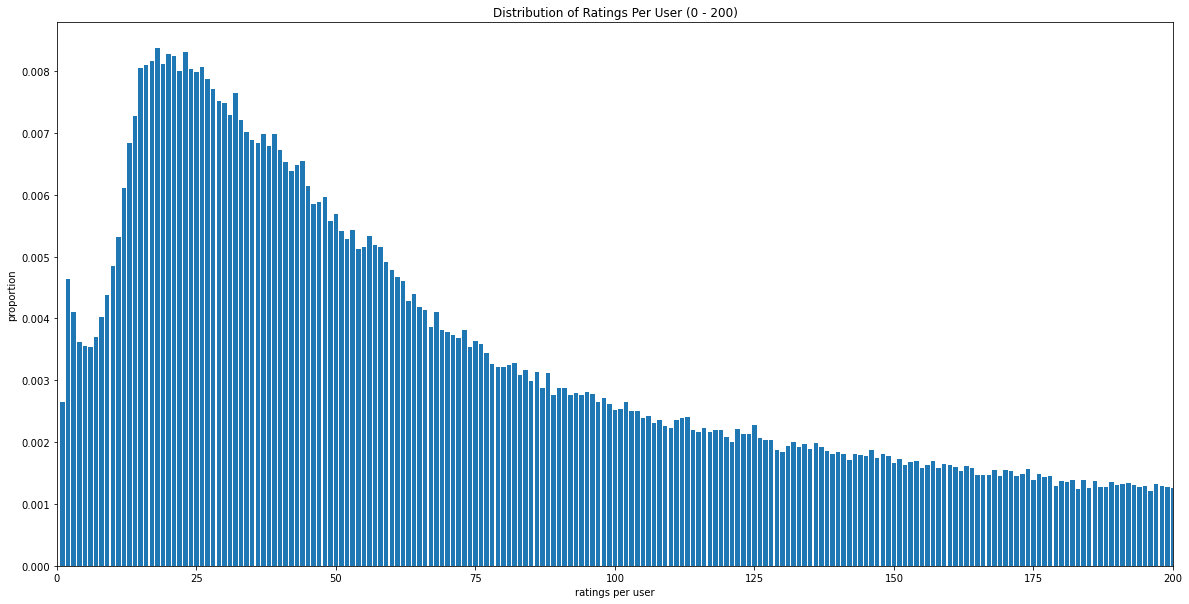

In [24]:
fig, axes3 = plt.subplots(figsize=(20,10))
axes3.bar(x = user_rating_cnt_props.index,
          height = user_rating_cnt_props.values)
axes3.set_xlim(left = 0, right = 200)
axes3.set_xlabel("ratings per user")
axes3.set_ylabel("proportion")
axes3.set_title("Distribution of Ratings Per User (0 - 200)")
plt.show()

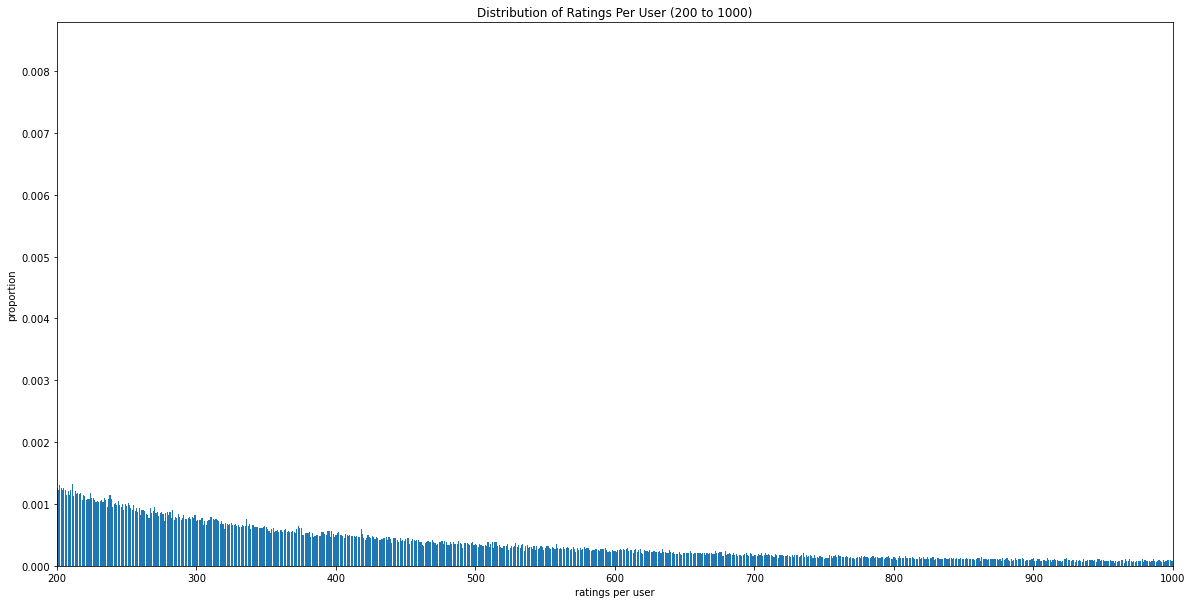

In [25]:
fig, axes4 = plt.subplots(figsize=(20,10))
axes4.bar(x = user_rating_cnt_props.index,
          height = user_rating_cnt_props.values)
axes4.set_xlim(left = 200, right = 1000)
axes4.set_xlabel("ratings per user")
axes4.set_ylabel("proportion")
axes4.set_title("Distribution of Ratings Per User (200 to 1000)")
plt.show()

The number of ratings given by each user peaks from 14 to 32. Most users gave few ratings (<50) and few gave many. 

### Distribution of number of ratings each movie received

In [26]:
movies_by_rating_cnt = df.groupby('movie_id').count()['user_id'].reset_index()

In [27]:
movies_by_rating_cnt.rename(columns = {"user_id": "rating_count"}, inplace=True)

In [28]:
movies_by_rating_cnt.sort_values('rating_count', ascending=False)

,movie_id,rating_count
12569,5317,232944
5696,15124,216596
4795,14313,200832
5786,15205,196397
8778,1905,193941
...,...,...
12001,4806,13
13612,6256,10
1496,11344,10
1278,11148,5


The number of ratings each movie received varies tremendously from 3 to 232944.

array([[<AxesSubplot:title={'center':'rating_count'}>]], dtype=object)

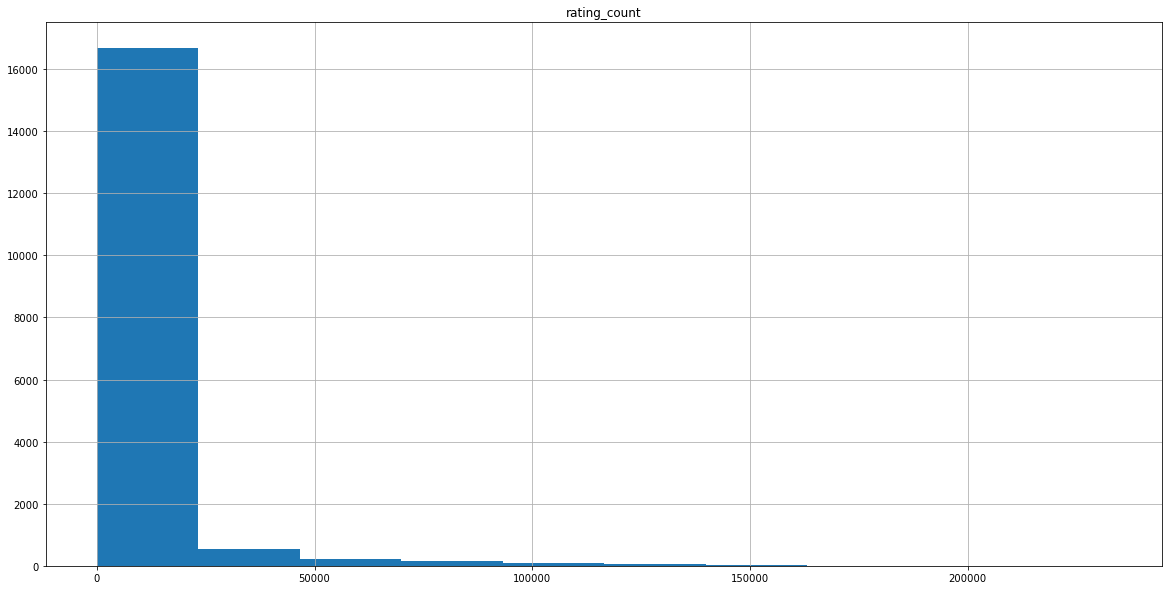

In [29]:
movies_by_rating_cnt.hist(column = 'rating_count', figsize = (20,10))

The distribution of the number of ratings each movie received is excessively right-skewed as well. The majority of movies received less than 25000 ratings. Let's get a more detailed picture of the trend using narrower bins (bin width = 100) for smaller values of x (0-10000) and wider bins (bin width = 1000) for larger values of x (10001-240000).


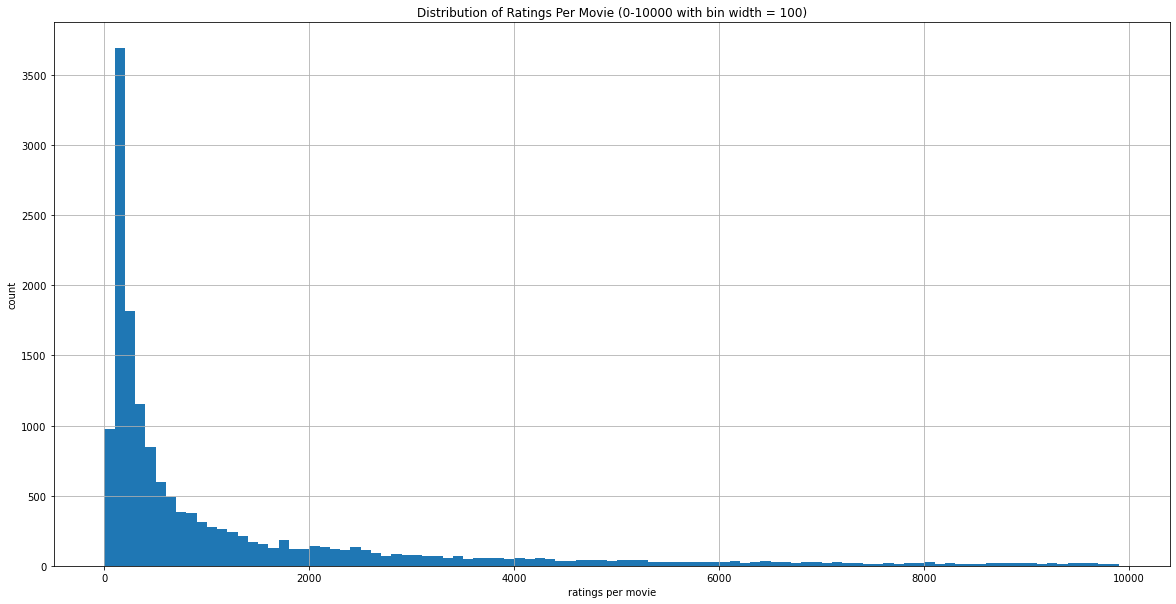

In [30]:
movies_by_rating_cnt.hist(column = 'rating_count', figsize = (20,10), bins = range(0,10000,100))
plt.xlabel("ratings per movie")
plt.ylabel("count")
plt.title("Distribution of Ratings Per Movie (0-10000 with bin width = 100)")
plt.show()

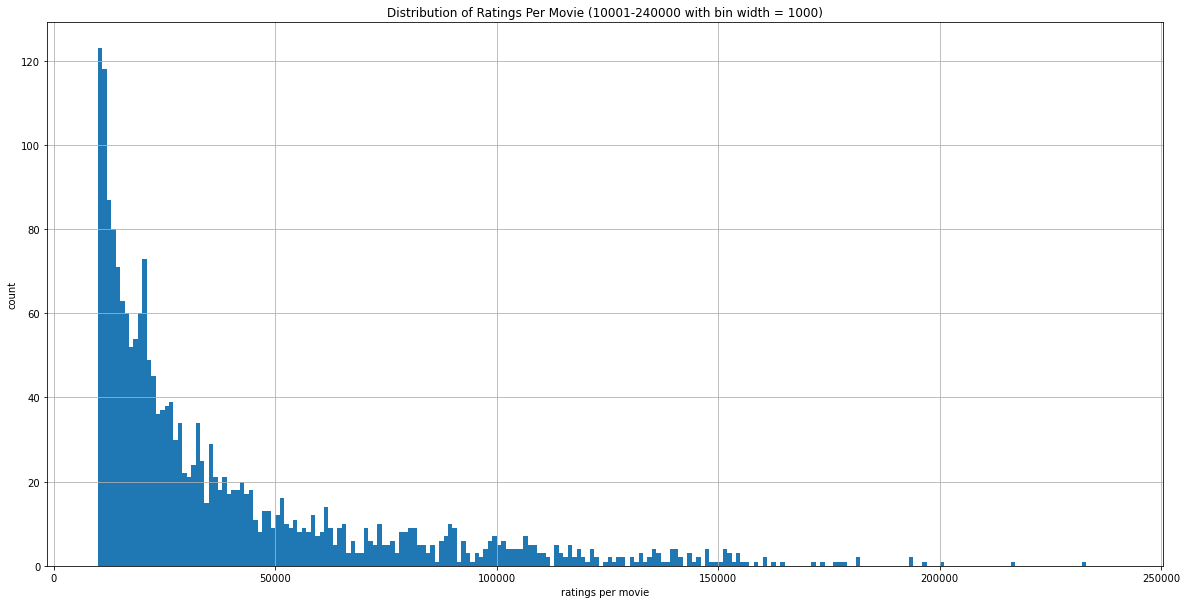

In [31]:
movies_by_rating_cnt.hist(column = 'rating_count', figsize = (20,10), bins = range(10001,240000,1000))
plt.xlabel("ratings per movie")
plt.ylabel("count")
plt.title("Distribution of Ratings Per Movie (10001-240000 with bin width = 1000)")
plt.show()

For movies that received fewer ratings (fewer than 10000), the number of ratings per movie peaks at 100-200 ratings, and decays rapidly afterwards. Among movies that received many ratings (over 10000), most received fewer than 21000 ratings.   

exploratory analyses to do next:
- The rating distributions (mean, variance) of the top 10 most popular (most rated) movies
- The rating distribution of movies that received few ratings (<=200)
- Distribution of ratings from users who rated few movies (<=50)
- Distribution of ratings from users who rated many movies (>=1000)


For building a recommendation system, need to do subsampling of the original dataset. Ideas for sampling:
1. After merging the 4 subsets of data, randomly sample 50% (or 25%?) of users
2. After merging the 4 subsets of data, select movies with many ratings and users who rated many movies.


In [32]:
top_10_movies = movies_by_rating_cnt.sort_values('rating_count', ascending=False).head(n=10)['movie_id'].values
top_10_movies

array(['5317', '15124', '14313', '15205', '1905', '6287', '11283',
       '16377', '16242', '12470'], dtype=object)

In [61]:
df

,user_id,rating,movie_id
0,1488844,3.0,1
1,822109,5.0,1
2,885013,4.0,1
3,30878,4.0,1
4,823519,3.0,1
...,...,...,...
100480502,1790158,4.0,17770
100480503,1608708,3.0,17770
100480504,234275,1.0,17770
100480505,255278,4.0,17770


In [33]:
df_top10 = df[df['movie_id'].isin(top_10_movies)]

In [34]:
print(df_top10.shape)
print(df_top10.head())

(1952563, 3)
         user_id  rating movie_id
9687179  1046323     4.0     1905
9687180  2450541     5.0     1905
9687181  2173336     4.0     1905
9687182   364518     3.0     1905
9687183   716091     3.0     1905


In [35]:
df_top10.groupby('movie_id').mean()['rating']

movie_id
11283    4.299910
12470    3.411870
14313    3.783854
15124    3.724238
15205    3.442166
16242    3.454411
16377    4.306941
1905     4.153908
5317     3.361267
6287     3.905047
Name: rating, dtype: float64

In [36]:
df_top10.groupby('movie_id').var()['rating']

movie_id
11283    0.816840
12470    1.132944
14313    1.203312
15124    1.079766
15205    1.208468
16242    1.124582
16377    0.736108
1905     0.822837
5317     1.235790
6287     1.056821
Name: rating, dtype: float64

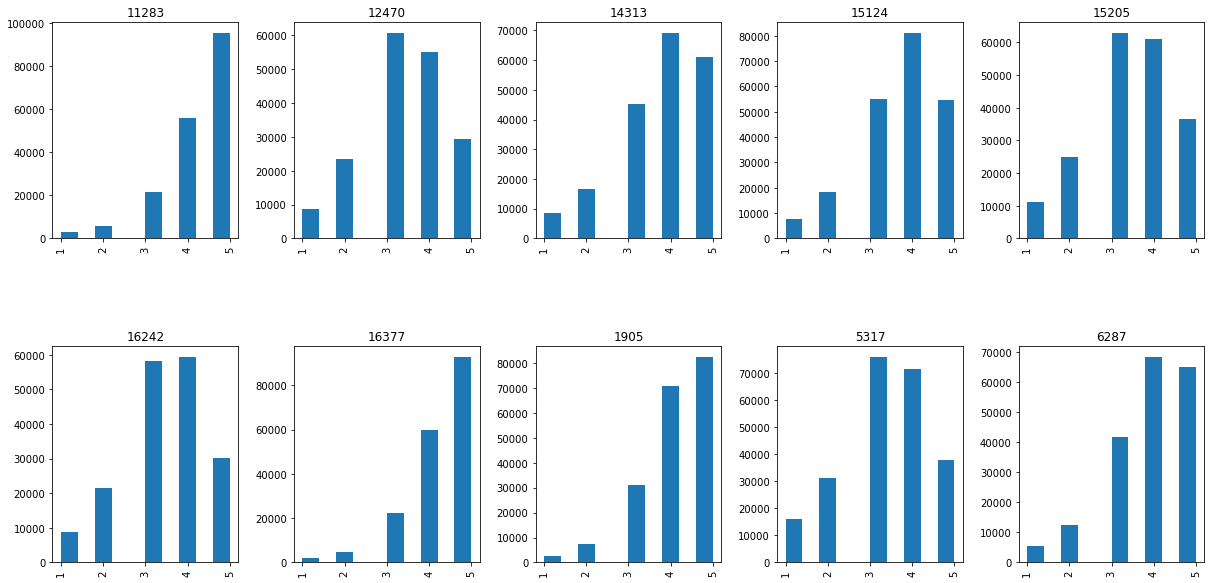

In [37]:
top10_hist = df_top10.hist(column = 'rating', by = 'movie_id', figsize = (20,10), layout = (2,5))
plt.show()

Among the 10 most popular movies (received most ratings), ratings on movies 11283, 16377, and 1905 have the highest mean and lowest variance. Users had mixed attitudes towards the other 7 movies.

In [39]:
unpopular_movies = movies_by_rating_cnt[movies_by_rating_cnt['rating_count'] <= 200]['movie_id'].values

In [41]:
len(unpopular_movies)

4693

In [40]:
df_unpopular = df[df['movie_id'].isin(unpopular_movies)]

array([[<AxesSubplot:title={'center':'rating'}>]], dtype=object)

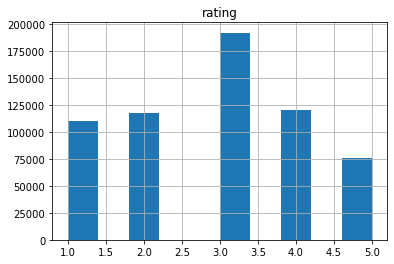

In [48]:
df_unpopular.hist(column = 'rating')

Among those movies which received no more than 200 ratings, many received mediocre ratings. There are more lower ratings (1 and 2) than higher ratings (4 and 5). A lot of variability in ratings for those movies. 

In [50]:
users_w_few_ratings = users_by_rating_cnt[users_by_rating_cnt['rating_count']<=50]['user_id'].values

In [51]:
users_w_few_ratings

array(['100000', '1000004', '1000038', ..., '999921', '999936', '99994'],
      dtype=object)

In [52]:
len(users_w_few_ratings)

155718

In [53]:
df_users_w_few_ratings = df[df['user_id'].isin(users_w_few_ratings)]

In [54]:
print(df_users_w_few_ratings.head())
print(df_users_w_few_ratings.shape)

     user_id  rating movie_id
23   2165002     4.0        1
39   2421815     2.0        1
86   2477242     5.0        1
94   1245406     4.0        1
135   317050     5.0        1
(4167501, 3)


First, look at the distribution of ratings across those users who rated <=50 movies.

array([[<AxesSubplot:title={'center':'rating'}>]], dtype=object)

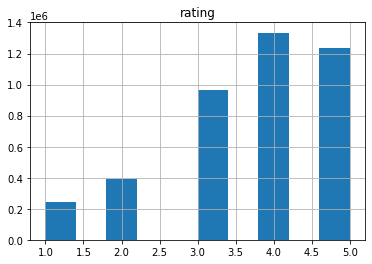

In [55]:
df_users_w_few_ratings.hist(column = 'rating')

The distribution is left skewed. Users who made few ratings (<=50) tend to give higher ratings.

Let's investigate the distribution from the individual level.

<AxesSubplot:>

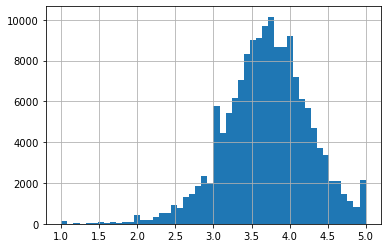

In [56]:
df_users_w_few_ratings.groupby('user_id').mean()['rating'].hist(bins=50)

<AxesSubplot:>

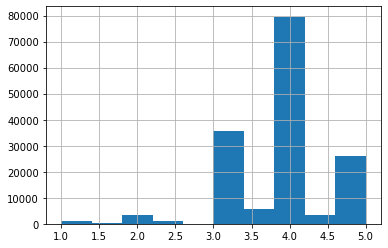

In [57]:
df_users_w_few_ratings.groupby('user_id').median()['rating'].hist()

Both the mean and the median ratings of each user are on the high end of the spectrum: the means peak around 3.75 while the medians peak at 4. Very few users gave low ratings of 1 or 2.

In [58]:
users_w_many_ratings = users_by_rating_cnt[users_by_rating_cnt['rating_count']>=1000]['user_id'].values

In [59]:
users_w_many_ratings

array(['1000192', '1000301', '1000387', ..., '99939', '999410', '999504'],
      dtype=object)

In [60]:
df_users_w_many_ratings = df[df['user_id'].isin(users_w_many_ratings)]

In [61]:
print(df_users_w_many_ratings.shape)
print(df_users_w_many_ratings.head())

(18786256, 3)
    user_id  rating movie_id
0   1488844     3.0        1
3     30878     4.0        1
7   1248029     3.0        1
19   372233     5.0        1
20  1080361     3.0        1


First, look at the distribution of ratings across those users who rated >=1000 movies.

array([[<AxesSubplot:title={'center':'rating'}>]], dtype=object)

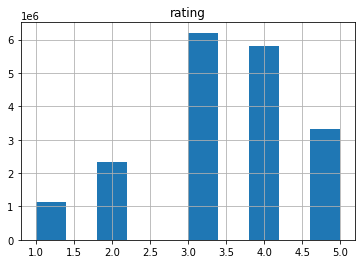

In [62]:
df_users_w_many_ratings.hist(column = 'rating')

The distribution is left skewed. However, unlike the distribution for users who rated <=50 movies, the distribution for users who rated >=1000 movies peaks at 3. User who rated many movies generally gave lower ratings than those who rated few.

Let's take a look at the distribution of ratings from an individual level.

<AxesSubplot:>

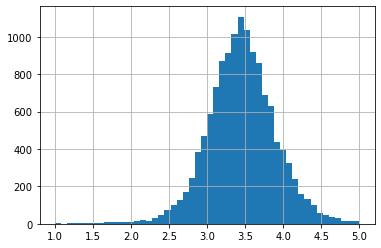

In [63]:
df_users_w_many_ratings.groupby('user_id').mean()['rating'].hist(bins = 50)

The distribution of the mean rating by each user looks like a normal distribution with the mean slightly below 3.5. 

<AxesSubplot:>

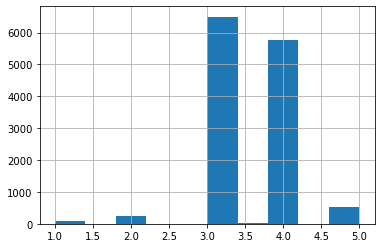

In [64]:
df_users_w_many_ratings.groupby('user_id').median()['rating'].hist()

The distribution of the median ratings are concentrated at 3 and 4, with very few low (1 and 2) and very high (5) ratings. 
So users who rated many movies tend to give lower ratings than those who rated few movies. 

## Try filtering out users who rated <=50 movies & movies which received <= 200 ratings

In [65]:
df_filtered = df[(~df['user_id'].isin(users_w_few_ratings)) & (~df['movie_id'].isin(unpopular_movies))]

In [67]:
df_filtered.shape

(95726056, 3)

In [69]:
df_filtered['user_id'].isin(users_w_few_ratings).sum()

0

In [72]:
df_filtered['movie_id'].isin(unpopular_movies).sum()

0

In [73]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95726056 entries, 0 to 100480506
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user_id   object 
 1   rating    float64
 2   movie_id  object 
dtypes: float64(1), object(2)
memory usage: 2.9+ GB


In [74]:
df_filtered.reset_index(drop=True)

,user_id,rating,movie_id
0,1488844,3.0,1
1,822109,5.0,1
2,885013,4.0,1
3,30878,4.0,1
4,823519,3.0,1
...,...,...,...
95726051,1790158,4.0,17770
95726052,1608708,3.0,17770
95726053,234275,1.0,17770
95726054,255278,4.0,17770


In [75]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95726056 entries, 0 to 100480506
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user_id   object 
 1   rating    float64
 2   movie_id  object 
dtypes: float64(1), object(2)
memory usage: 2.9+ GB


In [76]:
df_filtered.to_csv('filtered_data.txt')